In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import altair as alt

In [2]:
%matplotlib inline

In [3]:
# Import data and create df

data = pd.read_csv("/Users/Stacy/Documents/WebDevelopment/projects/sexualAssault_datasets/2010-2018_sexcrimes_violentcrimes.csv", index_col="CAD Event Number")
data = pd.DataFrame(data)

In [4]:
# Rename columns to be pythonic

data.columns = ['event_clearing', 'call_type', 'priority', 
                'initial_call_type', 'final_call_type', 'original_time_queued',
               'arrived_time', 'precinct', 'sector', 'beat']

In [5]:
# ID all calls cancelled by dispatch

cancelled_calls = data[data.event_clearing.str.contains("CANCELLED")]

# Delete rows with cxl'd calls

data = data[data.event_clearing != 'RESPONDING UNIT(S) CANCELLED BY RADIO']
data = data[data.event_clearing != 'DUPLICATED OR CANCELLED BY RADIO']

#### Clean time values

In [6]:
# Change original_time_queued to datetime
data['original_time_queued'] = pd.to_datetime(data.original_time_queued)

# Change arrived_time to datetime
data['arrived_time'] = pd.to_datetime(data.arrived_time, format='%b %d %Y %I:%M:%S:%f%p')

# Add time delta between original_time_queued and arrived_time
data['time_delta'] = ((data.arrived_time - data.original_time_queued)/np.timedelta64(1, 's')).astype(int)

In [7]:
# Add columns for arrived year and month
data['year'] = data.arrived_time.dt.year
data['month'] = data.arrived_time.dt.month

# Where arrive_time year = 1900, change data.year and data.month to original_time_queued year
mask = data.year < 1901
column_name_year = 'year'
column_name_month = 'month'
data.loc[mask, column_name_year] = data.original_time_queued.dt.year
data.loc[mask, column_name_month] = data.original_time_queued.dt.month

#### Define terms

In [8]:
# Define TRU initial call types
TRU_call_types = [
    'TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS)',
    'TRU - RAPE',
    'TRU - LEWD CONDUCT',
    'TRU - CHILD ABUSED, NEGLECTED',
    'TRU - THREATS',
    'TRU - ROBBERY',
    'TRU - ASLT - MOLESTED ADULT (GROPED, FONDLED, ETC)',
    'TRU - HARASSMENT',
    'TRU - SEX IN PUBLIC',
    'TRU - THEFT',
    'TRU - FOLLOW UP',
    'TRU - MVC - HIT AND RUN',
    'TRU - LURING',
    'TRU - FORGERY/CHKS/BUNCO/SCAMS/ID THEFT',
    'TRU - SUSPICIOUS CIRCUMSTANCES']

In [9]:
# Define terms that ID which crime_type

# Define terms that ID rape CFS
rape_terms = 'Stranger|Acquaintance'
rape_call_types = [
    'Acquaintance Rape',
    'Stranger Rape']
    #'--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    #'--RAPE - UNKNOWN SUSPECT (STRANGER)']

# Define terms that ID sex crimes
sex_crime_terms = 'CSEC|Lewd|Molesting|Stranger|Acquaintance'
sex_crime_call_types = [
    'Lewd Conduct',
    'Acquaintance Rape',
    'Stranger Rape',
    'Molesting',
    'CSEC']
   # '--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT',
    #'--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    #'--RAPE - UNKNOWN SUSPECT (STRANGER)',
    #'--SEX OFFENSES (RAPE) - MOLESTING',
    #'--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)']

# Define terms that ID other violent crimes
violent_crime_terms = 'Kidnap|Homicide|Shooting|Assault|Robbery'
violent_crime_call_types = [
    '--ASSAULTS - FIREARM INVOLVED',
    '--ROBBERY - ARMED',
    '--HOMICIDE',
    '--KIDNAP - GENERAL',
    '--DRIVE BY SHOOTING - NO INJURIES']

#### fyi: Original Call Types

--ASSAULTS - FIREARM INVOLVED'
'--ROBBERY - ARMED'

'--HOMICIDE'

'--KIDNAP - GENERAL'
'--DRIVE BY SHOOTING - NO INJURIES'
--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT'
'--RAPE - KNOWN SUSPECT (ACQUAINTANCE)'
'--RAPE - UNKNOWN SUSPECT (STRANGER)'
'--SEX OFFENSES (RAPE) - MOLESTING'
'--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)

In [13]:
# Replace final_call_type values to english
# DRY this. oof.

# Seriously. Look at this. oof.

data['final_call_type'] = data['final_call_type'].replace("--HOMICIDE", "Homicide")
data['final_call_type'] = data['final_call_type'].replace("--ASSAULTS - FIREARM INVOLVED", "Assault w/ Firearm")
data['final_call_type'] = data['final_call_type'].replace("--ROBBERY - ARMED", "Armed Robbery")
data['final_call_type'] = data['final_call_type'].replace("--KIDNAP - GENERAL", "Kidnap")
data['final_call_type'] = data['final_call_type'].replace("--DRIVE BY SHOOTING - NO INJURIES", "Drive-by Shooting")
data['final_call_type'] = data['final_call_type'].replace("--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT", "Lewd Conduct")
data['final_call_type'] = data['final_call_type'].replace("--RAPE - KNOWN SUSPECT (ACQUAINTANCE)", "Acquaintance Rape")
data['final_call_type'] = data['final_call_type'].replace("--RAPE - UNKNOWN SUSPECT (STRANGER)", "Stranger Rape")
data['final_call_type'] = data['final_call_type'].replace("--SEX OFFENSES (RAPE) - MOLESTING", "Molesting")
data['final_call_type'] = data['final_call_type'].replace("--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)", "CSEC")

# Replace precinct names with lowercase
data['precinct'] = data['precinct'].replace('NORTH', 'North')
data['precinct'] = data['precinct'].replace('EAST', 'East')
data['precinct'] = data['precinct'].replace('SOUTH', 'South')
data['precinct'] = data['precinct'].replace('WEST', 'West')
data['precinct'] = data['precinct'].replace('SOUTHWEST', 'Southwest')
data['precinct'] = data['precinct'].replace('UNKNOWN', 'Unknown')

In [14]:
# Define clearing codes for is_arrest

arrest_cc = ['PHYSICAL ARREST MADE']

#### Add columns for is_arrest, is_TRU, crime_type

In [15]:
# Add column identifying if there was an arrest
data['is_arrest'] = np.where(data['event_clearing'].isin(arrest_cc), 'yes', 'no')

# Add column identifying if this was A TRU call
data['is_TRU'] = np.where(data['initial_call_type'].isin(TRU_call_types), 'yes', 'no')

In [16]:
# Add crime_type for each call type as a violent crime, sex crime or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)
is_lewd_conduct = data['final_call_type'].str.contains("Lewd")
is_arrest_mask = data['is_arrest'] == "yes"
is_tru_mask = data['is_TRU'] == "yes"

data['crime_type'] = np.where(data['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(data['final_call_type'].isin(sex_crime_call_types),
                                          'other sex crime', 'violent crime')))

## 1. 2018 Sees increase in reports of sex crimes


Seattle is a growing city. And it would be reasonable to expect an increase in crime to accompany more people living and working in the city. But something else is happening in Seattle. Despite a dramatic increase in population over the past few years, reports of violent crime have actually been steadily decreasing since 2015. Good news, right? Well, not entirely.

Over this same time period that saw reports of violent crimes decreasing, the city has experienced a steady increase in reports of rape since 2014. And other sex related crimes have nearly doubled since 2012.

2017 saw an increase in calls reporting sex crimes, whereas other violent crimes in the city continued a downward trend that began in 2015.

Reports of non-rape sex crime increased each year of this analysis except for 2012. Between 2010 and 2018 the number of calls reporting non-rape sex crimes has nearly doubled in Seattle.

In this same time period, Seattle saw a decrease in the reporting of non-sex-related violent crimes.

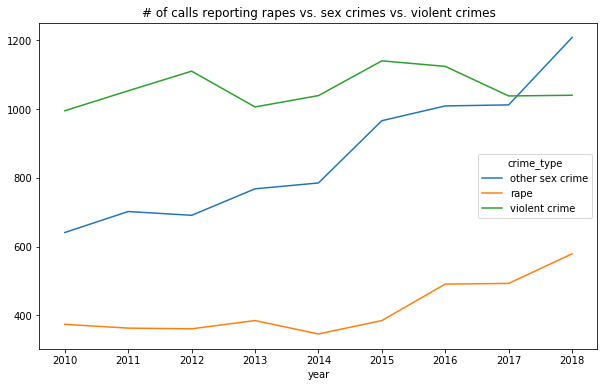

In [17]:
# Compare number of rape calls, non-rape sex crime calls, and violent crime calls by year

data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6),
    title="# of calls reporting rapes vs. sex crimes vs. violent crimes")

#### Altair Chart

In [18]:
# Create df for Altair
crime_type_counts = pd.DataFrame(data)

# Create crosstab with only counts of crime types
crime_type_counts = pd.crosstab(data.year, columns=data.crime_type)
crime_type_counts = crime_type_counts.stack().reset_index()
crime_type_counts = crime_type_counts.rename(columns={0: 'type_count'})

In [19]:
crime_type_counts.head()

,year,crime_type,type_count
0,2010,other sex crime,641
1,2010,rape,374
2,2010,violent crime,995
3,2011,other sex crime,702
4,2011,rape,363


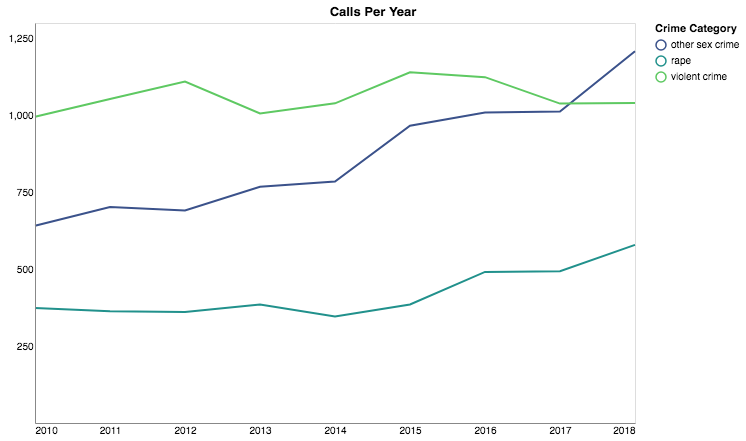

In [20]:
# Chart number of calls reporting each crime type

alt.Chart(crime_type_counts).mark_line().encode(
    x=alt.X('year', axis=alt.Axis(format='Y', title='', ticks=False)),
    y=alt.Y('type_count', axis=alt.Axis(title='', ticks=False, values=[250, 500, 750, 1000, 1250])),
    color=alt.Color('crime_type', legend=alt.Legend(title='Crime Category'), scale=alt.Scale(scheme='viridis')),
).properties(
    title='Calls Per Year',
    width=600,
    height=400
).configure_axis(
    grid=False
)

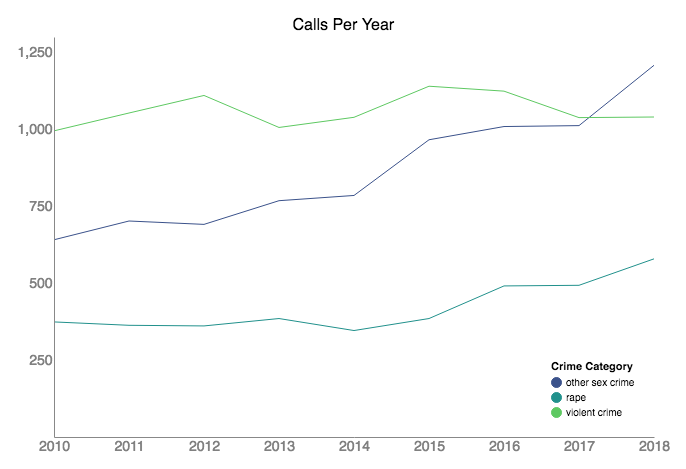

In [21]:
# Interactive crime_type counts chart! 

# Create selection that chooses the nearest point
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                       fields=['year'], empty='none')

# The basic line
line = alt.Chart().mark_line().encode(
    x=alt.X(
        'year:Q',
        axis=alt.Axis(
            format='Y',
            title='',
            ticks=False
        )),
    y=alt.Y(
        'type_count:Q',
        axis=alt.Axis(
            title='',
            ticks=False,
            values=[250, 500, 750, 1000, 1250]
        )),
    color=alt.Color(
        'crime_type:N',
        legend=alt.Legend(
            title='Crime Category',
            orient='bottom-right'
        ),
        scale=alt.Scale(
            scheme='viridis'
        ))
)

# Transparent selectors across the chart. This tells the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='year:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, highlight selection
text = line.mark_text(align='center', dx=0, dy=25).encode(
    text=alt.condition(nearest, 'type_count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='lightgray').encode(
    x='year:Q',
).transform_filter(
    nearest
)

# Put layers together and chart
alt.layer(
    line, selectors, points, rules, text,
    data=crime_type_counts,
    width=600,
    height=400,
    padding=15,
).properties(
    title='Calls Per Year'
).configure_line(
    strokeWidth=1,
).configure_text(
    fontSize=14,
    fontWeight=400,
    align='center',
).configure_title(
    fontSize=16,
    fontWeight=400
).configure_axis(
    labelFontSize=14,
    labelColor='gray',
    grid=False
).configure_view(
    strokeWidth=0
).configure_axisBottom(
    labelFlush=False
)


Between 2010 and 2018 there has been a general increase in the number of calls each year for lewd conduct. During this time period, number of lewd conduct calls in the North, East and West precincts have steadily increased. In the same time period, these calls in the South and Southwest precincts have remained mostly flat. 

In 2015 and 2018 there were marked increases in these calls in the North, East and West precincts.

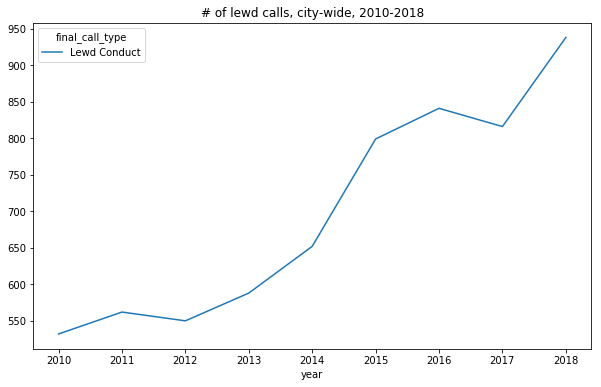

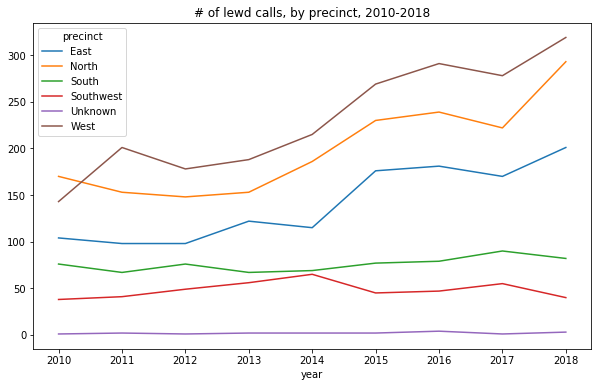

In [22]:
# Plot lewd conduct calls, by precinct, over the years
lewd_df = data[is_lewd_conduct]

lewd_df.groupby('final_call_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of lewd calls, city-wide, 2010-2018")

lewd_df.groupby('precinct').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of lewd calls, by precinct, 2010-2018")


### Altair Chart: Call Count by Final Call Type

In [23]:
# Create final call type df for Altair
fct_counts = pd.DataFrame(data)

# Create crosstab with only counts of final call types
fct_counts = pd.crosstab(fct_counts.year, columns=fct_counts.final_call_type)
fct_counts = fct_counts.stack().reset_index()
fct_counts = fct_counts.rename(columns={0: 'final_call_count'})

fct_counts.head()


,year,final_call_type,final_call_count
0,2010,Acquaintance Rape,214
1,2010,Armed Robbery,602
2,2010,Assault w/ Firearm,166
3,2010,CSEC,0
4,2010,Drive-by Shooting,118


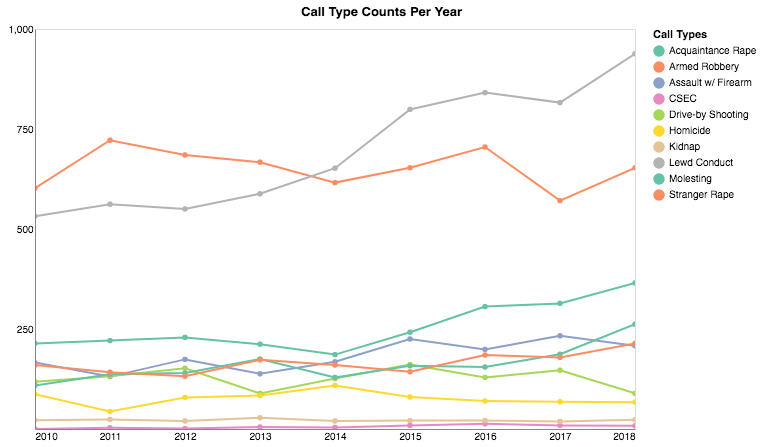

In [24]:
# Chart number of calls reporting each final call type

alt.Chart(fct_counts).mark_line(point=True).encode(
    x=alt.X('year', axis=alt.Axis(format='Y', title='', ticks=False)),
    y=alt.Y('final_call_count', axis=alt.Axis(title='', ticks=False, values=[250, 500, 750, 1000, 1250])),
    tooltip=('year','final_call_type:N','final_call_count:Q'),
    color=alt.Color(
        'final_call_type',
        legend=alt.Legend(
            title='Call Types'
        ), scale=alt.Scale(
            scheme='set2'
        ))
).properties(
    title='Call Type Counts Per Year',
    width=600,
    height=400
).configure_axis(
    grid=False
).interactive()

# To do: edit tooltips to remove labels and add "calls" after count.

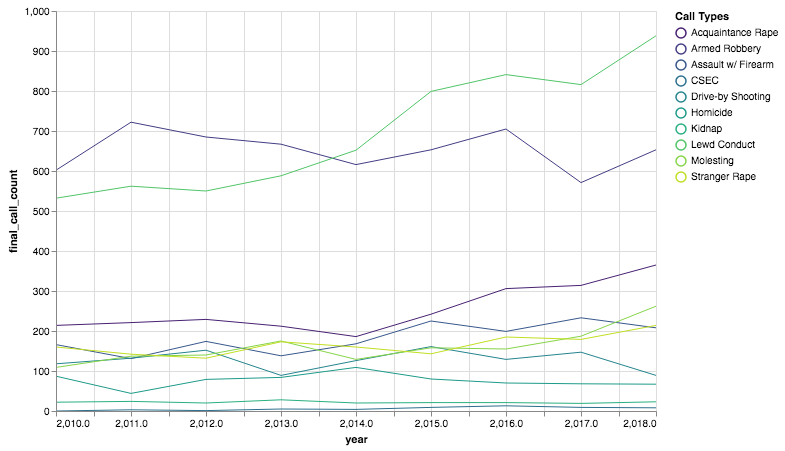

In [25]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['final_call_type'], nearest=True)

base = alt.Chart(fct_counts).encode(
    x='year',
    y='final_call_count',
    color=alt.Color(
        'final_call_type',
        legend=alt.Legend(
            title='Call Types'
        ), scale=alt.Scale(
            scheme='viridis'
        )
    )    
)

points = base.mark_line().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=600,
    height=400
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)


points + lines

In [26]:
fct_counts.head()

,year,final_call_type,final_call_count
0,2010,Acquaintance Rape,214
1,2010,Armed Robbery,602
2,2010,Assault w/ Firearm,166
3,2010,CSEC,0
4,2010,Drive-by Shooting,118


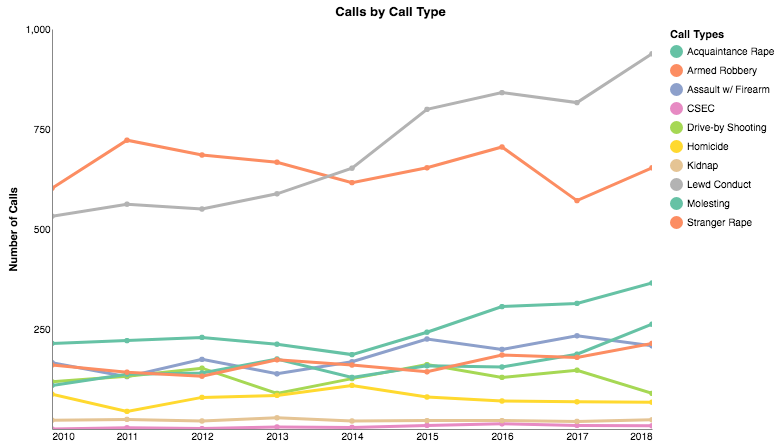

In [27]:
# USE
# Chart number of calls reporting each final call type

alt.Chart(fct_counts).mark_line(point=True).encode(
    x=alt.X('year',axis=alt.Axis(format='Y', title='', ticks=False)),
    y=alt.Y('final_call_count', axis=alt.Axis(title='Number of Calls', ticks=False, values=[250, 500, 750, 1000, 1250])),
    tooltip=('year','final_call_type:N', 'final_call_count'),
    color=alt.Color(
        'final_call_type',
        legend=alt.Legend(
            title='Call Types',
            orient='right'
        ), scale=alt.Scale(
            scheme='set2'
        ))
).properties(
    title='Calls by Call Type',
    width=600,
    height=400,
).configure_axis(
    grid=False
).configure_line(
    strokeWidth=3
).configure_view(
    strokeWidth=0
).interactive()

# To do: edit tooltips to remove labels and add "calls" after count.

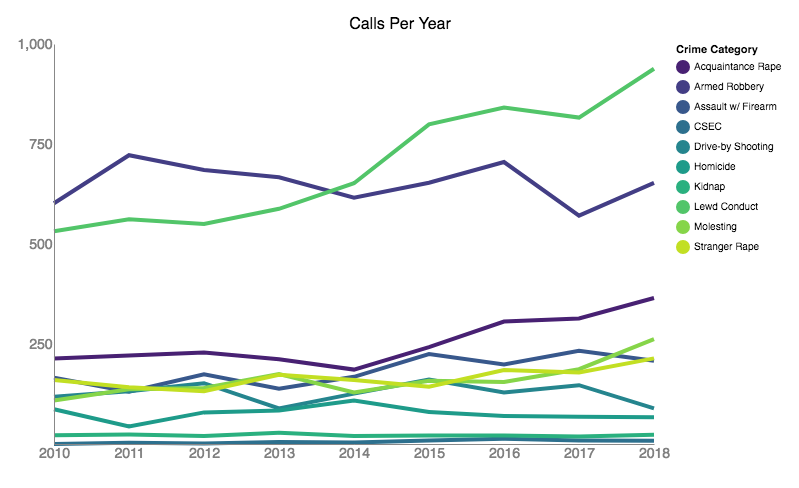

In [28]:
# Interactive crime_type counts chart! 

# Create selection that chooses the nearest point
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                       fields=['year'], empty='none')

# The basic line
line = alt.Chart().mark_line().encode(
    x=alt.X(
        'year:Q',
        axis=alt.Axis(
            format='Y',
            title='',
            ticks=False
        )),
    y=alt.Y(
        'final_call_count:Q',
        axis=alt.Axis(
            title='',
            ticks=False,
            values=[250, 500, 750, 1000, 1250]
        )),
    color=alt.Color(
        'final_call_type:N',
        legend=alt.Legend(
            title='Crime Category',
            orient='right'
        ),
        scale=alt.Scale(
            scheme='viridis'
        ))
)

# Transparent selectors across the chart. This tells the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='year:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, highlight selection
text = line.mark_text(align='center', dx=0, dy=25).encode(
    text=alt.condition(nearest, 'final_call_count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='lightgray').encode(
    x='year:Q',
).transform_filter(
    nearest
)

# Put layers together and chart
alt.layer(
    line, selectors, points, rules, text,
    data=fct_counts,
    width=600,
    height=400,
    padding=15,
).properties(
    title='Calls Per Year'
).configure_line(
    strokeWidth=4,
).configure_text(
    fontSize=14,
    fontWeight=400,
    align='center',
).configure_title(
    fontSize=16,
    fontWeight=400
).configure_axis(
    labelFontSize=14,
    labelColor='gray',
    grid=False
).configure_view(
    strokeWidth=0
).configure_axisBottom(
    labelFlush=False
)


## 2. Arrests for VC have increased

In 2018, the percentage rape calls that resulted in an arrests was 5.7%. That same year, the rate of arrest for violent crimes was nearly one and a half times higher at 13.8%. At the same time, Seattle saw reports of violent crimes drop for the third year in a row, while calls reporting rapes are at an all-time high. Since the #MeToo movement started towards the end of 2017, more victims have been coming forward to report sexual assaults. And, even though rapes are notoriously underreported, this increase in rape calls doesn't necessarily indicate and overall increase in these crimes.

Even though the number of arrests for non-sex-related violent crime was flat from 2017 to 2018, the rate of arrests (percentage) has increased because there's been a drop in reports of these crimes. Conversely, reports of rape have steadily increased since 2014. Understandibly, the number of calls that have resulted in arrest have also increased but the rate of arrests have not kept pace. Between 2015 and 2017 there was a dramatic decrease in arrest rates related to rape calls - dropping from a 7% arrest rate in 2015 to 3.4% in 2017. Last year, the arrest rate rebounded to 5.7%, but was still much lower than the high of 10.2% in 2012. And, given that last year's violent crime arrest rate of 13.75%, arrests rates for rape calls still lags.

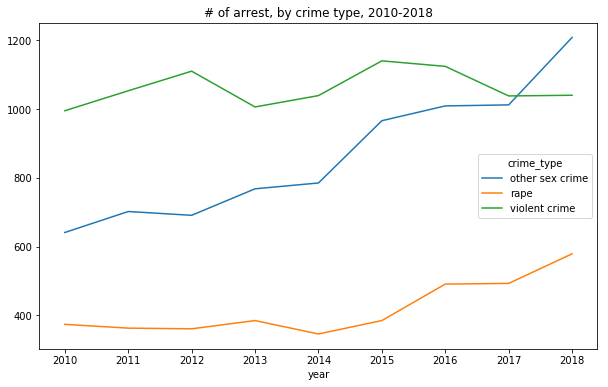

In [29]:
# Create df for all calls with an arrest

arrest_df = data['is_arrest'] == "yes"

# Plot the count of calls with an arrest, by year and crime type

data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of arrest, by crime type, 2010-2018")


In [30]:
# Calculate arrest percentages by crime type for each year
arrest_percent_by_yr = pd.crosstab([data.crime_type, data.year],data.is_arrest,
                         normalize = 'index')

# Multiply all percentages by 100 for graphing. 
arrest_percent_by_yr *= 100

# Flatten df
arrest_percent_by_yr.reset_index(inplace=True)

# Remove "no" percentages
arrest_percent_by_yr = arrest_percent_by_yr.drop('no', axis=1)

In [31]:
# Separate data by crime type for visualization

vc_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("violent")]
rape_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("rape")]
other_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("other")]

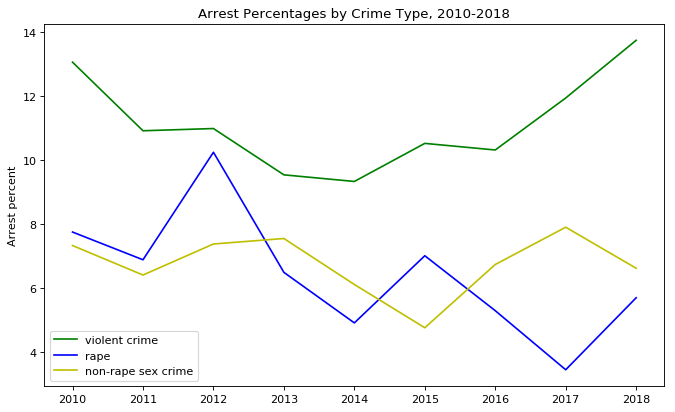

In [32]:
# Plot arrests percentges by year.

plt.figure(figsize=(10,6), dpi= 80)
plt.plot(vc_arr_by_yr.year, vc_arr_by_yr.yes, color='g', label='violent crime')
plt.plot(rape_arr_by_yr.year, rape_arr_by_yr.yes, color='b', label='rape')
plt.plot(other_arr_by_yr.year, other_arr_by_yr.yes, color='y', label='non-rape sex crime')

plt.ylabel('Arrest percent')
plt.title('Arrest Percentages by Crime Type, 2010-2018')
plt.legend()

plt.show()

## 3. TRU Calls


In [33]:
# Create crosstab to view % all TRU calls by crime type

percentage_tru_calls = pd.crosstab(data.final_call_type,data.is_TRU,
                          normalize = 'index').rename_axis(None)



percentage_tru_calls

is_TRU,no,yes
Acquaintance Rape,0.975972,0.024028
Armed Robbery,0.999149,0.000851
Assault w/ Firearm,0.990256,0.009744
CSEC,0.980769,0.019231
Drive-by Shooting,0.999125,0.000875
Homicide,1.000000,0.000000
Kidnap,0.989899,0.010101
Lewd Conduct,0.990761,0.009239
Molesting,0.971763,0.028237
Stranger Rape,0.986559,0.013441


Sex crimes where there is a victim, are initially sent to TRU at higher rates than other violent crimes. For the nine years of police calls examined, non-sex-related violent crimes sent to TRU averaged less than 1% of the time. In the same time period, 2.4% of calls reporting acquaintance rape and 2.8% of molestation were sent to TRU.

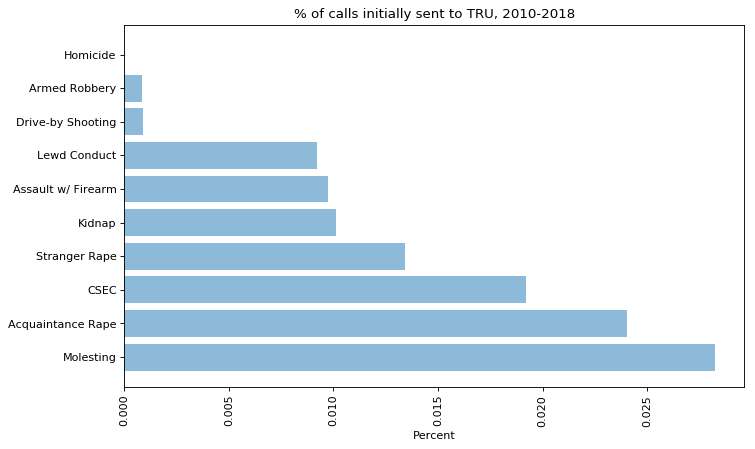

In [34]:
# Plot TRU call percentages as bar graph. 

percentage_tru_sorted = percentage_tru_calls.sort_values('yes',ascending=False)

plt.figure(figsize=(10,6), dpi= 80)
plt.barh(percentage_tru_sorted.index, percentage_tru_sorted.yes, align='center', alpha=0.5)
plt.xlabel('Percent')
plt.title('% of calls initially sent to TRU, 2010-2018')
plt.xticks(rotation=90)

plt.show()

An average of 2.8% of the calls reporting molesting were sent to TRU. 

Even though the overall number of rape calls initially sent to the Telephone Reporting Unit is low, it still means that 75 people called the Seattle Police Department to report a rape and were directed to the same police unit that would handle a call reporting a bicycle that was stolen two years ago.

Between 2010 and 2018, 55 acquaintance rape calls, 20 stranger rape calls and 41 molesting calls were referred to TRU.

**Insert viz showing number of rape and molesting calls sent to TRU**

tutorial: https://pudding.cool/process/flexbox-layout/

In [35]:
# Sandbox to confirm number of TRU molesting and rape calls

data_tru_df = data[is_tru_mask]
data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Molesting")]
#data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Acquaintance")]
#data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Stranger")]

#data_tru_df.count()

## 4. Lewd Calls

Demonstrate the connections between the amount of time between when the call was taken and when the first officer arrived on scene and the call outcome.

In [36]:
# Create df for all in progress lewd calls with bad arrived_time rows removed
# total i/p lewd calls = 5673

lewd_calls_ip = data[data.arrived_time > '1900-1-1']
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.final_call_type.str.contains("LEWD")]
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.priority <= 3]

In [37]:
# View count of clearing codes
# lewd_calls_ip.event_clearing.value_counts()

In [38]:
# Refine df to only include the 5 most common clearing codes
# 90% of all calls were cleared with one of these clearing calls

top_lewd_cc_terms = 'REPORT WRITTEN|ASSISTANCE RENDERED|PHYSICAL ARREST|UNABLE TO LOCATE|ORAL WARNING'
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.event_clearing.str.contains(top_lewd_cc_terms)]

#### Altair Chart: Lewd Calls

In [39]:
# Create lewd conduct df for Altair
lewd_call_df = pd.DataFrame(data)

# Remove all calls that are not for lewd conduct
lewd_call_df = lewd_call_df[lewd_call_df.final_call_type.str.contains('Lewd')]
# Remove calls where precinct is unknown
lewd_call_df = lewd_call_df[lewd_call_df.precinct != "Unknown"]

# Create crosstab with only counts of lewd conduct calls
lewd_call_df = pd.crosstab(lewd_call_df.year, columns=[lewd_call_df.final_call_type, lewd_call_df.precinct])
lewd_call_df = lewd_call_df.stack().reset_index()
lewd_call_df = lewd_call_df.rename(columns={'Lewd Conduct':'lewd_conduct'})

lewd_call_df.head()

final_call_type,year,precinct,lewd_conduct
0,2010,East,104
1,2010,North,170
2,2010,South,76
3,2010,Southwest,38
4,2010,West,143


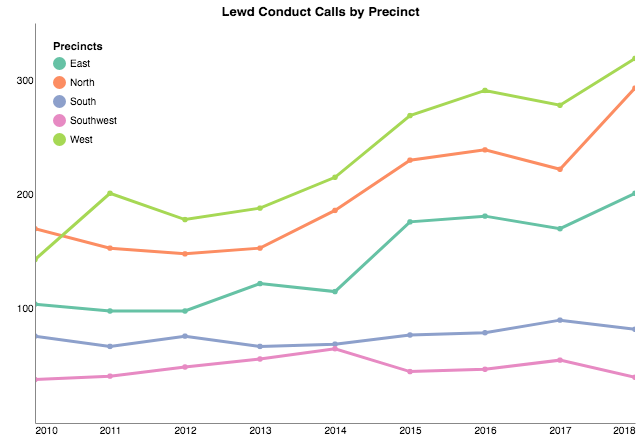

In [40]:
# USE
# Chart number of calls reporting each final call type

alt.Chart(lewd_call_df).mark_line(point=True).encode(
    x=alt.X('year',axis=alt.Axis(format='Y', title='', ticks=False)),
    y=alt.Y('lewd_conduct', axis=alt.Axis(title='', ticks=False, values=[100, 200, 300])),
    tooltip=('precinct', 'year','lewd_conduct'),
    color=alt.Color(
        'precinct',
        legend=alt.Legend(
            title='Precincts',
            orient='top-left'
        ), scale=alt.Scale(
            scheme='set2'
        ))
).properties(
    title='Lewd Conduct Calls by Precinct',
    width=600,
    height=400
).configure_axis(
    grid=False
).configure_line(
    strokeWidth=3
).configure_view(
    strokeWidth=0
).interactive()

# To do: edit tooltips to remove labels and add "calls" after count. Change axis font label formatting

In [41]:
lewd_call_df.head()

final_call_type,year,precinct,lewd_conduct
0,2010,East,104
1,2010,North,170
2,2010,South,76
3,2010,Southwest,38
4,2010,West,143


In [42]:
lewd_call_total_df = lewd_call_df.groupby('year').sum()
lewd_call_total_df = lewd_call_total_df.stack().reset_index()
lewd_call_total_df = lewd_call_total_df.rename(columns={0: 'type_count'})
lewd_call_total_df

,year,final_call_type,type_count
0,2010,lewd_conduct,531
1,2011,lewd_conduct,560
2,2012,lewd_conduct,549
3,2013,lewd_conduct,586
4,2014,lewd_conduct,650
5,2015,lewd_conduct,797
6,2016,lewd_conduct,837
7,2017,lewd_conduct,815
8,2018,lewd_conduct,935


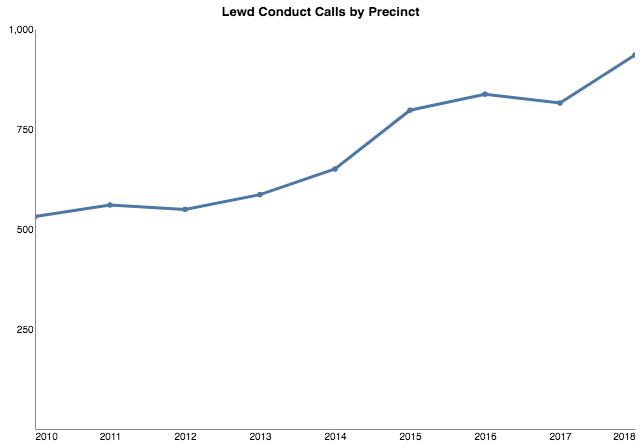

In [43]:
# USE
# Chart number of lewd conduct calls each year

alt.Chart(lewd_call_total_df).mark_line(point=True).encode(
    x=alt.X('year',axis=alt.Axis(format='Y', title='', ticks=False)),
    y=alt.Y('type_count', axis=alt.Axis(title='', ticks=False, values=[250, 500, 750, 1000])),
    tooltip=('year','type_count')
).properties(
    title='Lewd Conduct Calls by Precinct',
    width=600,
    height=400
).configure_axis(
    grid=False
).configure_line(
    strokeWidth=3
).configure_view(
    strokeWidth=0
).interactive()

# To do: edit tooltips to remove labels and add "calls" after count. Change axis font label formatting

## 5. Mapping Calls



In [44]:
data.head()

,event_clearing,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat,time_delta,year,month,is_arrest,is_TRU,crime_type
CAD Event Number,,,,,,,,,,,,,,,,
2010000066820,ASSISTANCE RENDERED,911,2,MENTAL - PERSON OR PICKUP/TRANSPORT,Lewd Conduct,2010-02-27 22:54:25,2010-02-27 22:55:45,North,UNION,U1,80,2010,2,no,no,other sex crime
2010000000327,PHYSICAL ARREST MADE,911,1,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),Assault w/ Firearm,2010-01-01 03:13:06,2010-01-01 03:14:51,South,ROBERT,R3,105,2010,1,yes,no,violent crime
2010000000451,REPORT WRITTEN (NO ARREST),911,2,THEFT OF SERVICES,Armed Robbery,2010-01-01 05:46:54,2010-01-01 06:39:35,North,UNION,U1,3161,2010,1,no,no,violent crime
2010000000466,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",3,RAPE,Acquaintance Rape,2010-01-01 06:28:49,2010-01-01 06:40:09,East,GEORGE,G1,680,2010,1,no,no,rape
2010000000776,REPORT WRITTEN (NO ARREST),911,3,RAPE,Acquaintance Rape,2010-01-01 15:05:57,2010-01-01 15:12:26,Southwest,FRANK,F3,389,2010,1,no,no,rape


## 6. Create Sankey diagram:
* five horizontal flows corresponding to one of ~5-6 time_delta buckets
* final checkpoint goes to how the call was cleared.

* final_call_type --> time_delta (bins) --> event_clearing

Export dataframes to csv

In [32]:
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  data['final_call_type'].dropna(axis=0, how='any'),
#       color = data['Color']
    ),
    link = dict(
      source = data['original_time_queued'].dropna(axis=0, how='any'),
      target = data['time_delta'].dropna(axis=0, how='any'),
      value = data['event_clearing'].dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Title",
    height = 772,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

In [27]:
percentage_tru_sorted

is_TRU,no,yes
Molesting,0.971763,0.028237
Acquaintance Rape,0.975972,0.024028
CSEC,0.980769,0.019231
Stranger Rape,0.986559,0.013441
Kidnap,0.989899,0.010101
Assault w/ Firearm,0.990256,0.009744
Lewd Conduct,0.990761,0.009239
Drive-by Shooting,0.999125,0.000875
Armed Robbery,0.999149,0.000851
Homicide,1.000000,0.000000


In [28]:
# Sandbox for downloading data for import to Tableau

#data_tru_df.to_csv('tru_df.csv')
#lewd_calls_ip.to_csv('lewd_calls_ip_df.csv')
#lewd_df.to_csv('lewd_df.csv')
# data.to_csv('data_df.csv')
#arrest_percent_by_yr.to_csv('arrest_percent_by_yr.csv')
#percentage_tru_sorted.to_csv('percent_tru.csv')
#vc_arr_by_yr.to_csv('vc_arrest.csv')
#rape_arr_by_yr.to_csv('rape_arrest.csv')
#other_arr_by_yr.to_csv('other_arrest.csv')

### Mapping with Altair